<a href="https://colab.research.google.com/github/Pranav-2509/NIGHT_VISION_SELF/blob/main/Paper_Implementation_Retinex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

#Importing the Dataset containing low light and well lit image pairs



In [38]:
pip install "deeplake<4"

In [39]:
import deeplake
ds = deeplake.load('hub://activeloop/lowlight-train')

/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lowlight-train



-

hub://activeloop/lowlight-train loaded successfully.



In [40]:
dataloader = ds.pytorch(num_workers=0, batch_size=10, shuffle=False)

In [41]:
first_batch = next(iter(dataloader))

# Check the contxents of the first batch
images_0, images_1, indices = first_batch  # Assuming the DataLoader returns a tuple of (images, labels)

# Print the shapes of the images and labels
print("Images shape:", images_0.shape)
print("Labels shape:", images_1.shape)

# Optionally, print the first image and its label to see actual data
print("First image tensor:", images_0[0])
print("First label:", images_1[0])

Images shape: torch.Size([10, 400, 600, 3])
Labels shape: torch.Size([10, 400, 600, 3])
First image tensor: tensor([[[ 86,  82,  80],
         [ 87,  82,  79],
         [ 86,  82,  80],
         ...,
         [132, 132, 138],
         [132, 132, 138],
         [132, 133, 138]],

        [[ 86,  82,  79],
         [ 86,  79,  79],
         [ 86,  80,  79],
         ...,
         [132, 133, 139],
         [132, 133, 139],
         [132, 132, 139]],

        [[ 84,  77,  77],
         [ 86,  79,  80],
         [ 84,  82,  79],
         ...,
         [132, 133, 139],
         [132, 132, 139],
         [135, 133, 138]],

        ...,

        [[ 77,  71,  71],
         [ 73,  70,  71],
         [ 75,  71,  73],
         ...,
         [152, 163, 178],
         [155, 165, 178],
         [155, 165, 179]],

        [[ 73,  70,  71],
         [ 73,  71,  70],
         [ 79,  75,  73],
         ...,
         [154, 163, 177],
         [154, 163, 181],
         [155, 165, 179]],

        [[ 75,  70

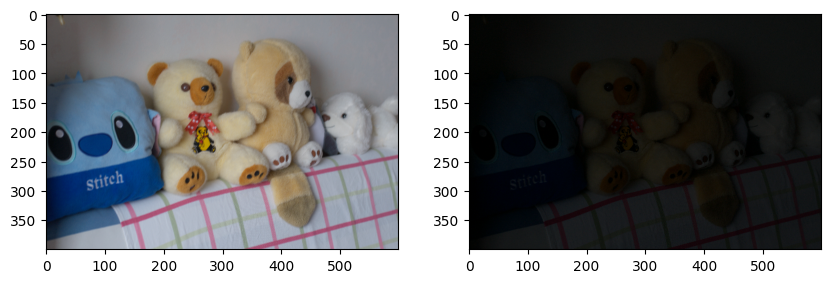

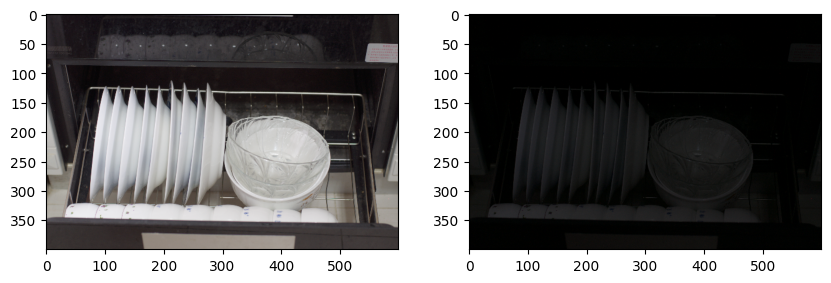

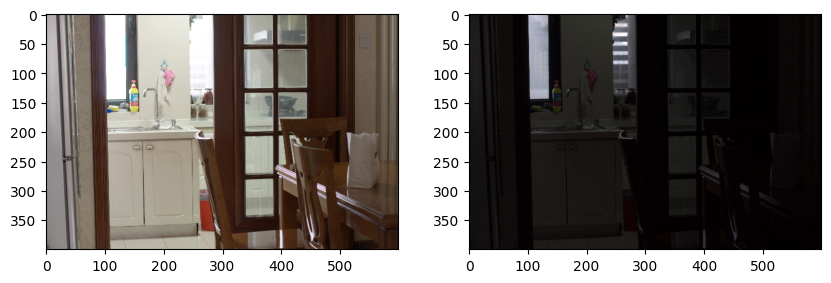

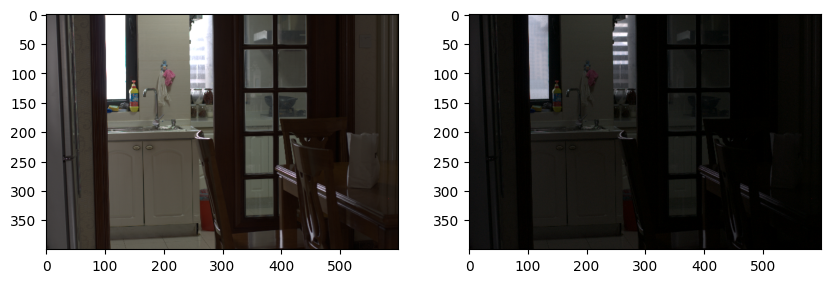

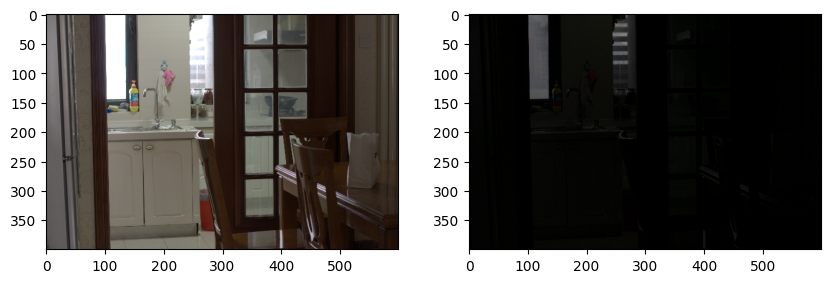

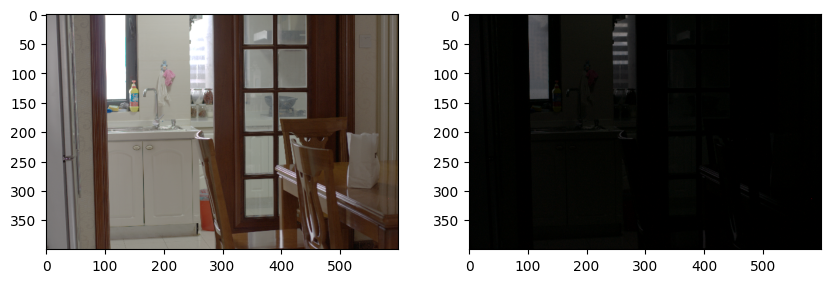

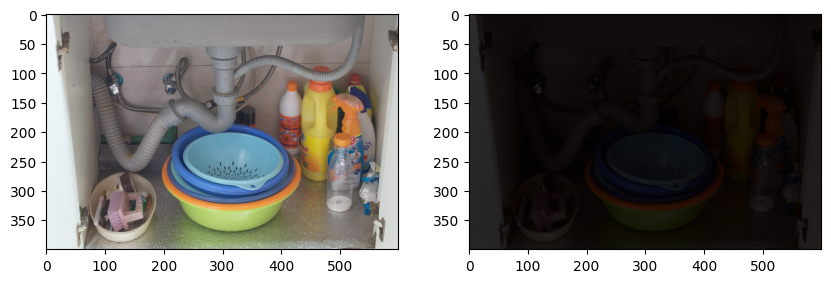

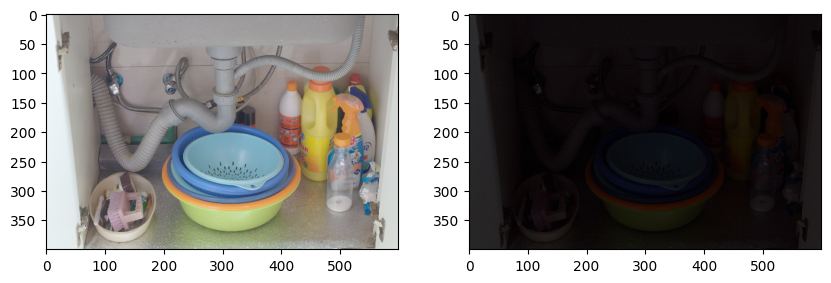

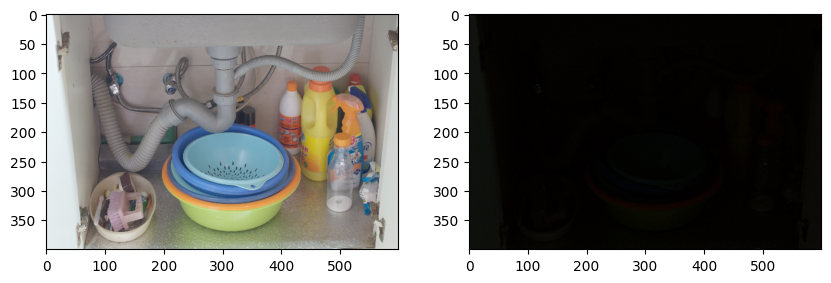

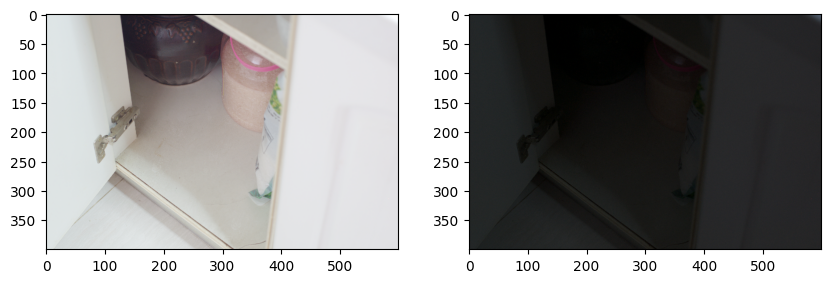

In [42]:
#Printing out some of the data

for i in range (len(images_0)):
  img0 = images_0[i].numpy()
  img1 = images_1[i].numpy()
  img0 = img0.astype (np.uint8)
  img1 = img1.astype (np.uint8)


  fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
  axes[0].imshow(img0)
  axes[1].imshow(img1)

  plt.show()





#Transforms

In [43]:
from torchvision import transforms

transform = transforms.Compose([
    # Convert integer tensor to float32
    transforms.Lambda(lambda x: x.to(torch.float32)),

    # Resize to 100x150
    transforms.Resize((100, 150)),

    # Normalize using mean and standard deviation
    # Example: Assuming an RGB image, you might normalize each channel separately
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust mean/std as needed
])

#Assigning device

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


#Decom Net (Image Decomposition)

In [45]:
class DecomNet (nn.Module):
  def __init__ (self, hidden_size):
    super(DecomNet, self).__init__()
    self.Conv1 = nn.Conv2d (in_channels = 3, out_channels = hidden_size, kernel_size = 3, stride = 1, padding = 1)
    self.Conv2 = nn.Conv2d (in_channels = hidden_size, out_channels = hidden_size, kernel_size = 3, stride = 1, padding = 1)
    self.Conv3 = nn.Conv2d (in_channels = hidden_size, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)
    self.Conv4 = nn.Conv2d (in_channels = 3, out_channels = hidden_size, kernel_size = 3, stride = 1, padding = 1)
    self.Conv5 = nn.Conv2d (in_channels = hidden_size, out_channels = hidden_size, kernel_size = 3, stride = 1, padding = 1)
    self.Conv6 = nn.Conv2d (in_channels = hidden_size, out_channels = 1, kernel_size = 3, stride = 1, padding = 1)

    self.activation1 = nn.LeakyReLU()
    self.activation2 = nn.ReLU()

  def forward (self, img):
    reflectance_map = self.activation1 (self.Conv1(img))
    reflectance_map = self.activation1 (self.Conv2(reflectance_map))
    reflectance_map = self.activation1 (self.Conv2(reflectance_map))
    reflectance_map = self.activation2 (self.Conv3 (reflectance_map))

    illumination_map = self.activation1 (self.Conv4(img))
    illumination_map = self.activation1 (self.Conv5(illumination_map))
    illumination_map = self.activation1 (self.Conv5(illumination_map))
    illumination_map = self.activation2 (self.Conv6 (illumination_map))
    return (reflectance_map, illumination_map)


In [46]:
Decom_Net = DecomNet (64).to(device)

In [47]:
img = torch.rand ((4, 3, 40, 60)).to (device)
ref_map, ill_map = Decom_Net (img)
print (ref_map.shape, ill_map.shape)

torch.Size([4, 3, 40, 60]) torch.Size([4, 1, 40, 60])


#Calculating The Loss

In [48]:
class decomnet_loss (nn.Module):
  def __init__(self, mew):
    super(decomnet_loss, self).__init__()
    self.mew = mew

  def forward (self, input_image, ref_map,ref_maps_2, ill_map):
      batch_size, channels, ht, wd = input_image.shape
      recon_img = ref_map * ill_map
      diff = input_image - recon_img

      norm_1 = torch.sum(torch.abs(diff))
      ht, width = input_image.shape[2], input_image.shape[3]
      max_tensor = torch.empty((0, 1, ht, width)).to (device)

      for i in range (batch_size):
        img = input_image[i]
        max_tensor_img = torch.max(img[0], torch.max(img[1], img[2]))
        max_tensor_img = max_tensor_img.unsqueeze(dim = 0)
        max_tensor_img = max_tensor_img.unsqueeze(dim = 0)
        max_tensor = torch.cat ((max_tensor, max_tensor_img), dim = 0)

      diff_2 = max_tensor - ill_map
      norm_2 = torch.norm(diff_2, p=2)

      diff_3 = ref_maps - ref_maps_2
      norm_3 = torch.sum (torch.abs(diff_3))

      total_loss = norm_1 + self.mew*(norm_2)**2 + norm_3

      return total_loss

In [49]:
criterion = decomnet_loss(mew = 0.1).to (device)

## Illumination Enhancement Module

#Enhance - Net




In [50]:
batch_size = 10

In [51]:
#It takes as input, the batch of low light images
#Size of input = (batch_size, 3, ht, width)
#Size of output = same as input

class Enhance_Net (nn.Module):
  def __init__ (self, hidden_size):
    super (Enhance_Net, self).__init__()
    self.layer1 = nn.Conv2d (in_channels = 3, out_channels = hidden_size, padding = 1, kernel_size = 3)
    self.layer2 = nn.Conv2d (in_channels = hidden_size, out_channels = hidden_size, padding = 1, kernel_size = 3)
    self.layer3 = nn.Conv2d (in_channels = hidden_size, out_channels = 3, padding = 1, kernel_size = 3)
    self.activation = nn.ReLU()
    self.activation2 = nn.Sigmoid()
    self.normalisation = nn.BatchNorm2d (num_features = hidden_size)

  def forward (self, x):    #Here 'x' is the batch of 4 low light images
    x_copy = x.clone()
    x = self.activation (self.layer1(x))
    x_copy2 = x.clone()
    x = self.activation (self.normalisation(self.layer2(x)))
    x = x + x_copy2
    x = self.activation2 (self.layer3(x))
    x = x + x_copy

    return (x)

In [52]:
enhance_net = Enhance_Net (hidden_size = 64).to (device)


In [53]:
inpt = torch.rand ((batch_size, 3, 40, 60)).to (device)
output = enhance_net(inpt)

print (output.shape)

torch.Size([10, 3, 40, 60])


#Correction Unit

In [54]:
#Takes as input 2 tensors each of dimn (batch_size, 3, ht, width)
#output dimension = (batch_size, 3, ht, width)


from torchvision.ops import SqueezeExcitation

class Correction_Unit (nn.Module):
  def __init__(self, hidden_channels):
    super (Correction_Unit, self).__init__()
    self.se_block = SqueezeExcitation(input_channels = 2*hidden_channels, squeeze_channels= hidden_channels)

    self.layer1 = nn.Conv2d (in_channels = 3, out_channels = hidden_channels, kernel_size = 3, padding = 1)
    self.layer2 = nn.Conv2d (in_channels = 3, out_channels = hidden_channels, kernel_size = 3, padding = 1)
    self.layer3 = nn.Conv2d (in_channels = 2*hidden_channels, out_channels = hidden_channels, padding = 1, kernel_size = 3)
    self.layer4 = nn.Conv2d (in_channels = hidden_channels, out_channels = hidden_channels, padding = 1, kernel_size = 3)
    self.layer5 = nn.Conv2d (in_channels = hidden_channels, out_channels = hidden_channels, padding = 1, kernel_size = 3)
    self.layer6 = nn.Conv2d (in_channels = hidden_channels, out_channels = 3, padding = 1, kernel_size = 3)


    self.normalisation = nn.BatchNorm2d (num_features = hidden_channels)
    self.activation1 = nn.ReLU()
    self.activation2 = nn.Sigmoid()

  def forward (self, ref_map, ill_map):
    ref_map_copy = ref_map.clone()
    ref_map = self.activation1 (self.layer1(ref_map))
    ill_map = self.activation1 (self.layer2(ill_map))
    x = torch.cat ((ref_map, ill_map), dim = 1)
    x = self.se_block (x)
    x = self.activation1(self.normalisation(self.layer3(x)))
    for i in range (3):
      x_copy = x.clone()
      x = self.activation1(self.normalisation(self.layer4(x)))
      x = self.activation1(self.normalisation(self.layer5(x)))
      x = x + x_copy

    x = self.activation2 (self.layer6(x))
    x = x + ref_map_copy

    return x




In [55]:
correction_unit = Correction_Unit (64). to (device)
i1 = torch.rand ((4, 3, 40, 60)).to (device)
i2 = torch.rand ((4, 3, 40, 60)).to(device)
output = correction_unit(i1, i2)

print (output.shape)

torch.Size([4, 3, 40, 60])


#Integrating the Enhancement Net and Correction Unit into the Illumination Enhancement Module

In [56]:
class Illumination_Enhancement (nn.Module):
  def __init__(self, T, Decom_Net):                      #The parameter 'T' mentioned in the paper
    super (Illumination_Enhancement, self).__init__()
    self.corr_unit  = Correction_Unit (64)
    self.enhance_net = Enhance_Net (64)
    self.Decom_Net = Decom_Net
    self.T = T


  def forward (self, x):
    batch_size, channels, height, width = x.shape
    L_t = torch.empty((0, batch_size, 3, height, width)).to (device)
    S_t = torch.empty ((0, batch_size, 3, height, width)).to (device)
    x_copy = x.clone()
    ref_maps, ill_maps = self.Decom_Net (x)
    for i in range (self.T):

        x = self.enhance_net (x)
        if (i >= 1):

          L_t = torch.cat ((L_t, x.unsqueeze(0)), dim = 0)

        if (i == self.T-1):
          return (x, L_t, S_t)                         #See the architecture closely for what happens in the last iteration

        x = self.corr_unit (ref_maps, x)
        x = x + x_copy

        if (i>=0):
          S_t = torch.cat ((S_t, x.unsqueeze(0)), dim = 0)

In [57]:
illumination_enhancement = Illumination_Enhancement (3, Decom_Net).to (device)
input_batch_images = torch.rand ((4, 3, 40, 60)).to (device)
final_output, L_t, S_t = illumination_enhancement (input_batch_images)


print (final_output.shape, L_t.shape, S_t.shape)

torch.Size([4, 3, 40, 60]) torch.Size([2, 4, 3, 40, 60]) torch.Size([2, 4, 3, 40, 60])


#Reflectance Denoising Module

In [58]:
class RefDenoising(nn.Module):
    def __init__(self, hidden_channel):
        super(RefDenoising, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=hidden_channel, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, padding=1)
        self.layer3 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, padding=1)
        self.layer5 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, padding=1)
        self.layer7 = nn.Conv2d(in_channels=hidden_channel, out_channels=3, kernel_size=3, padding=1)

        self.activation = nn.ReLU()
        self.se_block = SqueezeExcitation(input_channels=hidden_channel, squeeze_channels=hidden_channel)

    def forward(self, x):
        x_copy = x.clone()  # Save the original input for residual connection
        x = self.activation(self.layer1(x))
        x = self.se_block(x)  # Squeeze-and-Excitation block
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.activation(self.layer5(x))
        x = self.activation(self.layer6(x))
        x = self.layer7(x)  # Output layer
        x = x + x_copy  # Add the original input for residual learning
        return x

In [59]:
ref_denoising = RefDenoising(64).to (device)
i1 = torch.rand ((4, 3, 40, 60)).to (device)
output= ref_denoising(i1)
print(output.shape)

torch.Size([4, 3, 40, 60])


In [60]:
class Tot_ref_denoising (nn.Module):
  def __init__(self, T):
    super (Tot_ref_denoising, self).__init__()
    self.ref_denoising = RefDenoising (64)
    self.T = T


  def forward (self, R_low):
    batch_size, channels, height, width = R_low.shape
    intermediate_R = torch.empty ((0, batch_size, channels, height, width)). to (device)
    for i in range (self.T):
      R_low_copy = R_low.clone()
      R_low = self.ref_denoising (R_low)
      R_low = R_low + R_low_copy
      # print(R_low.shape,intermediate_R)
      intermediate_R = torch.cat ((intermediate_R, R_low.unsqueeze(0)), dim = 0)
      # print(R_low.shape,intermediate_R)

    return (R_low, intermediate_R)

In [61]:
T = 3

tot_ref_denoising = Tot_ref_denoising (T).to (device)
r_low = torch.rand ((4,3,40,60)).to (device)
output1, output2 = tot_ref_denoising (r_low)
print (output1.shape, output2.shape)

torch.Size([4, 3, 40, 60]) torch.Size([3, 4, 3, 40, 60])


#Ill - Enhancement Loss

In [62]:
class Enhancement_Loss (nn.Module):
  def __init__(self):
    super (Enhancement_Loss, self).__init__()


  def forward (self,ll_images, L_t, S_t, intermediate_R, R_low):
    T, _, _, _, _ = L_t.shape

    Fid_loss = 0
    ref_consistency = 0
    var_loss = 0

    for i in range (T):
      diff1 = L_t[i] - S_t[i] - ll_images
      loss1 = torch.norm(diff1, p=2)

      diff2 = intermediate_R[i] - R_low
      loss2 = torch.norm(diff2, p=2)

      R_tL_t = L_t[i]*intermediate_R[i]
      grad_y = R_tL_t[:, :, 1:, :] - R_tL_t[:, :, :-1, :]
      grad_x = R_tL_t[:, :, :, 1:] - R_tL_t[:, :, :, :-1]
      l1_norm_grad_y = torch.sum(torch.abs(grad_y))
      l1_norm_grad_x = torch.sum(torch.abs(grad_x))
      total_l1_norm = l1_norm_grad_y + l1_norm_grad_x

      Fid_loss = loss + Fid_loss
      ref_consistency = loss2 + ref_consistency
      var_loss = total_l1_norm + var_loss

    total_loss = 2*Fid_loss + ref_consistency + 0.1 * var_loss

    return (total_loss)

In [63]:
enhancement_loss = Enhancement_Loss()
# fid_loss = enhancement_loss (L_t, S_t)

#The Complete Model

In [64]:
class Complete_Model (nn.Module):
  def __init__(self):
    super (Complete_Model, self).__init__()
    self.Decom_Net = DecomNet (64)

    self.illumination_enhancement = Illumination_Enhancement (3, self.Decom_Net)

    self.tot_ref_denoising = Tot_ref_denoising (3)


  def forward (self, bright_images, ll_images):

    #Passing low light images through the Decom Net
    ref_maps, ill_maps = self.Decom_Net (ll_images)                  #output shape: (batch_size, 3, ht, wd) and (batch_size, 1, ht, wd)

    #Passing the bright images through Decom Net to obtain their ref_maps
    ref_maps_bright, ill_maps_bright = self.Decom_Net (bright_images)

    #Passing the low light images through the stacked Illumination Enhancement Network
    enhanced_ill_maps, L_t, S_t = self.illumination_enhancement (ll_images)  #output shapes: (batch_size, 3, ht, wd), (T-1, batch_size, 3, ht, wd),
                                                                                                                # (T-1, batch_size, 3, ht, wd)


    #Passing the Noisy Reflectance Maps through the Reflectance denoising Module
    enhanced_ref_maps , intermediate_ref_maps = self.tot_ref_denoising (ref_maps)  #output shapes : (batch_size, 3, ht, wd), (T, batch_size, 3, ht, wd)


    #Making sure gradients are being tracked
    ll_images = torch.tensor(ll_images, requires_grad=True)
    ref_maps = torch.tensor(ref_maps, requires_grad=True)
    ref_maps_bright = torch.tensor(ref_maps_bright, requires_grad=True)
    ill_maps = torch.tensor(ill_maps, requires_grad=True)
    L_t = torch.tensor(L_t, requires_grad=True)
    S_t = torch.tensor(S_t, requires_grad=True)
    intermediate_ref_maps = torch.tensor(intermediate_ref_maps, requires_grad=True)


    return (ll_images, ref_maps, ref_maps_bright, ill_maps, L_t, S_t, intermediate_ref_maps)



In [65]:
complete_model = Complete_Model().to (device)

bright_images = torch.rand ((4, 3, 40, 60)).to (device)
ll_images = torch.rand ((4, 3, 40, 60)).to (device)

ll_images, ref_maps, ref_maps_bright, ill_maps, L_t, S_t, intermediate_R = complete_model (bright_images, ll_images)


<ipython-input-64-294be4dd606d>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ll_images = torch.tensor(ll_images, requires_grad=True)
<ipython-input-64-294be4dd606d>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_maps = torch.tensor(ref_maps, requires_grad=True)
<ipython-input-64-294be4dd606d>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_maps_bright = torch.tensor(ref_maps_bright, requires_grad=True)
<ipython-input-64-294be4dd606d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

#The Complete Loss function

In [66]:
class Net_Loss (nn.Module):
  def __init__(self, mew):
    super (Net_Loss, self).__init__()
    self.mew = mew

  def forward (self, input_image, ref_map,ref_maps_2, ill_map, L_t, S_t, intermediate_R):

      batch_size = input_image.shape[0]

    # Decom - Net Loss

      recon_img = ref_map * ill_map
      diff = input_image - recon_img

      norm_1 = torch.sum(torch.abs(diff))
      ht, width = input_image.shape[2], input_image.shape[3]
      max_tensor = torch.empty((0, 1, ht, width)).to (device)

      for i in range (batch_size):
        img = input_image[i]
        max_tensor_img = torch.max(img[0], torch.max(img[1], img[2]))
        max_tensor_img = max_tensor_img.unsqueeze(dim = 0)
        max_tensor_img = max_tensor_img.unsqueeze(dim = 0)
        max_tensor = torch.cat ((max_tensor, max_tensor_img), dim = 0)

      diff_2 = max_tensor - ill_map
      norm_2 = torch.norm(diff_2, p=2)

      diff_3 = ref_map - ref_maps_2
      norm_3 = torch.sum (torch.abs(diff_3))

      decom_net_loss = norm_1 + self.mew*(norm_2)**2 + norm_3



      #Illumination and Reflectance denoising Loss

      T, _, _, _, _ = L_t.shape

      Fid_loss = 0
      ref_consistency = 0
      var_loss = 0

      for i in range (T):
        diff1 = L_t[i] - S_t[i] - input_image
        loss1 = torch.norm(diff1, p=2)

        diff2 = intermediate_R[i] - ref_map
        loss2 = torch.norm(diff2, p=2)

        R_tL_t = L_t[i]*intermediate_R[i]
        grad_y = R_tL_t[:, :, 1:, :] - R_tL_t[:, :, :-1, :]
        grad_x = R_tL_t[:, :, :, 1:] - R_tL_t[:, :, :, :-1]
        l1_norm_grad_y = torch.sum(torch.abs(grad_y))
        l1_norm_grad_x = torch.sum(torch.abs(grad_x))
        total_l1_norm = l1_norm_grad_y + l1_norm_grad_x

        Fid_loss = loss1 + Fid_loss
        ref_consistency = loss2 + ref_consistency
        var_loss = total_l1_norm + var_loss

      Illumination_Enhancement_loss = 2*Fid_loss + ref_consistency + 0.1 * var_loss

      total_loss = Illumination_Enhancement_loss + decom_net_loss

      return total_loss

In [67]:
input_image, ref_map,ref_maps_2, ill_map, L_t, S_t, intermediate_R, R_low = torch.rand((4, 3, 40, 60)).to (device), torch.rand((4, 3, 40, 60)).to (device),torch.rand((4, 3, 40, 60)).to (device), torch.rand((4, 1, 40, 60)).to (device),torch.rand((2, 4, 3, 40, 60)).to (device), torch.rand((2, 4, 3, 40, 60)).to (device), torch.rand((3, 4, 3, 40, 60)).to (device), torch.rand((4, 3, 40, 60)).to (device)

In [68]:
netloss = Net_Loss (0.1).to (device)

input_image = torch.tensor(input_image, requires_grad=True)
ref_map = torch.tensor(ref_map, requires_grad=True)
ref_maps_2 = torch.tensor(ref_maps_2, requires_grad=True)
ill_map = torch.tensor(ill_map, requires_grad=True)
L_t = torch.tensor(L_t, requires_grad=True)
S_t = torch.tensor(S_t, requires_grad=True)
intermediate_R = torch.tensor(intermediate_R, requires_grad=True)
R_low = torch.tensor(R_low, requires_grad=True)


tot_loss = netloss (input_image, ref_map,ref_maps_2, ill_map, L_t, S_t, intermediate_R)
print (tot_loss)

tot_loss.backward()

tensor(23599.1465, device='cuda:0', grad_fn=<AddBackward0>)


<ipython-input-68-f9f97f5b90a0>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_image = torch.tensor(input_image, requires_grad=True)
<ipython-input-68-f9f97f5b90a0>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_map = torch.tensor(ref_map, requires_grad=True)
<ipython-input-68-f9f97f5b90a0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_maps_2 = torch.tensor(ref_maps_2, requires_grad=True)
<ipython-input-68-f9f97f5b90a0>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

#Training Loop

In [69]:
learning_rate = 0.001
momentum = 0.1

optimizer = optim.SGD (complete_model.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
epochs = 100


for i in range (epochs):
  if (i==epochs-1):
    break
  # if (i==1):
  #   break
  epoch_loss = 0
  print (f"'\n' '\n' Epoch number  = {i+1} '\n' '\n'")

  for batch_index, (bright_images, ll_images, indices) in enumerate(dataloader):

    if (batch_index == 120):
      break


    bright_images = bright_images.permute(0, 3, 1, 2)
    ll_images = ll_images.permute(0, 3, 1, 2)
    bright_images = torch.tensor (bright_images, dtype = torch.float32)
    ll_images = torch.tensor (ll_images, dtype = torch.float32)
    ll_images = ll_images/255
    bright_images/=255


    central_height = 120
    central_width = 180

    # Calculate starting points to crop the center
    start_y = (400 - central_height) // 2  # Vertical starting point
    start_x = (600 - central_width) // 2    # Horizontal starting point

    # Extract the central region
    ll_images = ll_images[:, :, start_y:start_y + central_height, start_x:start_x + central_width]
    bright_images = bright_images[:, :, start_y:start_y + central_height, start_x:start_x + central_width]




    ll_images = ll_images.to(device)
    bright_images = bright_images.to (device)


    ll_images, ref_maps, ref_maps_bright, ill_maps, L_t, S_t, intermediate_R = complete_model (bright_images, ll_images)

    #Making sure gradients are being tracked
    ll_images = torch.tensor(ll_images, requires_grad=True)
    ref_maps = torch.tensor(ref_maps, requires_grad=True)
    ref_maps_bright = torch.tensor(ref_maps_bright, requires_grad=True)
    ill_maps = torch.tensor(ill_maps, requires_grad=True)
    L_t = torch.tensor(L_t, requires_grad=True)
    S_t = torch.tensor(S_t, requires_grad=True)
    intermediate_R = torch.tensor(intermediate_R, requires_grad=True)

    #Calculating the Net Total Loss
    Loss = netloss (ll_images, ref_maps, ref_maps_bright, ill_maps, L_t, S_t, intermediate_R)

    if (batch_index%30 == 0):

      print (f"Batch Index = {batch_index} '\n")
      print (Loss)
      print ("\n")

    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    # break


'
' '
' Epoch number  = 1 '
' '
'


<ipython-input-70-d2c89c90b293>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bright_images = torch.tensor (bright_images, dtype = torch.float32)
<ipython-input-70-d2c89c90b293>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ll_images = torch.tensor (ll_images, dtype = torch.float32)
<ipython-input-64-294be4dd606d>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ll_images = torch.tensor(ll_images, requires_grad=True)
<ipython-input-64-294be4dd606d>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceT

Batch Index = 0 '

tensor(40654.8516, device='cuda:0', grad_fn=<AddBackward0>)


Batch Index = 30 '

tensor(52046.7109, device='cuda:0', grad_fn=<AddBackward0>)




#Testing the Transforms

In [ ]:
#The first batch of low light images is images_0 of shape (batch_size, 3, ht, wd)

images_0 = images_0.permute(0, 3, 1, 2)
images_0 = torch.tensor (images_0, dtype = torch.float32)
images_0 = images_0/255


new_size = (40, 60)
images_0 = F.interpolate(images_0, size=new_size, mode='bilinear', align_corners=False)


def normalize_images(images):
    for i in range(images.size(0)):
        # For each image in the batch
        for c in range(images.size(1)):
            # Compute mean and std of the current channel
            channel_mean = images[i, c].mean()
            channel_std = images[i, c].std()

            # Normalize to zero mean and unit std
            images[i, c] = (images[i, c] - channel_mean) / (channel_std + 1e-8)

            # Rescale to mean=0.5 and std=0.5
            images[i, c] = images[i, c] * 0.5 + 0.5

    return images

# Apply normalization
normalized_images = normalize_images(images_0)

# Check the mean and std of the normalized images
for i in range(4):
    for c in range(3):
        mean = normalized_images[i, c].mean().item()
        std = normalized_images[i, c].std().item()
        print(f"Image {i+1}, Channel {c+1}: Mean = {mean:.3f}, Std = {std:.3f}")




#Testing

testing Decom Net forward pass

In [ ]:
print (img.shape)

In [ ]:
ref_low, ill_low = Decom_Net (img)

print (ref_low.shape, ill_low.shape)

Testing Illumination enhancement network's forward propagation

In [ ]:
enhanced_ill_map, L_t, S_t = illumination_enhancement (img)

print (enhanced_ill_map.shape, L_t.shape, S_t.shape)

Testing forward prop of the total Reflectance Denoising

In [ ]:
denoised_ref_map, intermediate_ref_maps = tot_ref_denoising(img)

print (denoised_ref_map.shape, intermediate_ref_maps.shape)

Testing out whether ill enhancement loss is working

In [ ]:
criterion = Enhancement_Loss ()

L_t.requires_grad_()  # In-place operation
S_t.requires_grad_()  # In-place operation
intermediate_ref_maps.requires_grad_()  # In-place operation
ref_low.requires_grad_()  # In-place operation


loss_1 = criterion (L_t, S_t, intermediate_ref_maps, ref_low)

loss_1.backward(retain_graph=True)
